# 태아의 건강상태 분류하기

## 개요

UN은 지속가능한 발전을 이루기 위해 2030년까지 태아와 만 5세 이하의 영유아의 사망률을 1000명당 25명 이하로 줄이는 것을 목표로 하고 있습니다. 그리고 이를 위해 학계에서는 CTGs라는 기술을 이용하여 태아의 vital sign(심박수,태동 등)과 산모의 건강상태(자궁수축 등)를 기록하여 데이터셋으로 만들었습니다. 

이 데이터셋은 총 2126명의 태아와 산모의 CTGs 기록들이 21개의 Feature들로 구분되어 제공되며, 우리가 분류해야할 Target은 태아의 건강상태로 3가지로 Multiclass Model을 구축해야 합니다.

출처 : https://www.kaggle.com/andrewmvd/fetal-health-classification

* baseline value : Baseline fetal heart rate(태아의 심박수를 가속과 감속을 제외하고, 10분을 평균낸 수치) - 110 ~ 160bpm, 변동성이 6 ~ 25bpm인 경우 정상 범위라고 합니다.


* accelerations : baseline FHR을 기록함에 있어 진폭과 주파수의 불규칙한 변동 중 분당 15회 이상, 15초 이상 지속되는 갑작스러운 증가를 의미합니다.


* fetal_movement : 초당 태동의 수


* uterine_contractions : 초당 자궁수축의 수


* light_decelerations : 자궁 수축에 따라 발생하는 가벼운 일시적인 심박감소로 초당 LD가 나타는 수가 데이터셋에 포함되었습니다. 


* severe_decelerations : 태아의 심박감소가 불규칙적으로 나타나는 상황으로 아이의 혈류가 감소한다는 신호일 수 있습니다. 


* prolongued_decelerations : 기초 FHR 이하로 15bpm 이상 감소되어 회복 시까지 2∼10 분 정도 deceleration이 지속되는 양상을 말합니다. 계속 지속될 경우 태아에 치명적인 문제가 발생한 것일 수 있다고 합니다.


* abnormal_short_term_variability : 비정상적인 단기 변동성의 비율


* mean_value_of_short_term_variability : 비정상적인 단기 변동의 평균


* percentage_of_time_with_abnormal_long_term_variability : 비정상적인 장기 변동성의 비율


* mean_value_of_long_term_variability : 장기변동의 평균


* histogram_width : FHR histogram의 width


* histogram_min : FHR histogram의 최저값


* histogram_max : FHR histogram 최댓값


* histogram_number_of_peaks : FHR histogram에서 peak가 나타난 횟수


* histogram_number_of_zeroes : FHR histogram에서 0이 나타난 횟수


* histogram_mode : FHR histogram의 mode


* histogram_mean : FHR histogram의 평균


* histogram_median : FHR histogram의 중앙값


* histogram_variance : FHR histogram의 분산


* histogram_tendency : FHR histogram의 Trend


* fetal_health(Target) : 1(Normal), 2(Suspect,병리적 현상의 의심됨), 3(Pathological, 병리적 현상이 나타남)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score
from sklearn.metrics import recall_score, f1_score

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

**데이터셋을 통해 분류를 한 뒤 이를 설명하기 위해서는 깊은 Domain지식이 필요합니다. 때문에 이번 문제에서는 Feature들을 바탕으로 Multi-classification 문제를 해결한다는 점에 의의를 두셨으면 합니다**

## Dataset Explanation

첨부된 데이터셋을 불러와주세요.

In [2]:
df = pd.read_csv('C:/Users/USER/BITAmin/data/fetal_health.csv')

# 1번

기술통계량과 결측치의 개수를 확인하여 아래의 질문에 답해주세요.

**1) 결측치의 개수**
: 0

**2) Baseline value의 표준편차**
: 9.840844

In [3]:
# 1) 결측치의 개수
df.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [4]:
# 2) Baseline value의 표준편차
df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


# 2번

EDA를 통해 데이터셋에 대한 전반적인 insight를 얻어봅시다!

**1) Pie chart를 통해 Fetal health의 분포를 확인해주세요.**

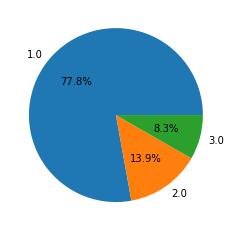

In [5]:
ratio = df['fetal_health'].value_counts().values
labels = df['fetal_health'].value_counts().index
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

Q. 위 그래프를 통해 어떤 결론에 도달할 수 있는지 서술해주세요.

Answer : 타겟 변수('fetal_health')의 클래스 불균형을 확인할 수 있습니다. 따라서 불균형 데이터 처리가 필요할 것 같습니다. 

**2) 아래 코드를 완성하여 Fetal Health를 제외한 Feature들의 전반적인 히스토그램을 그려주세요!.**

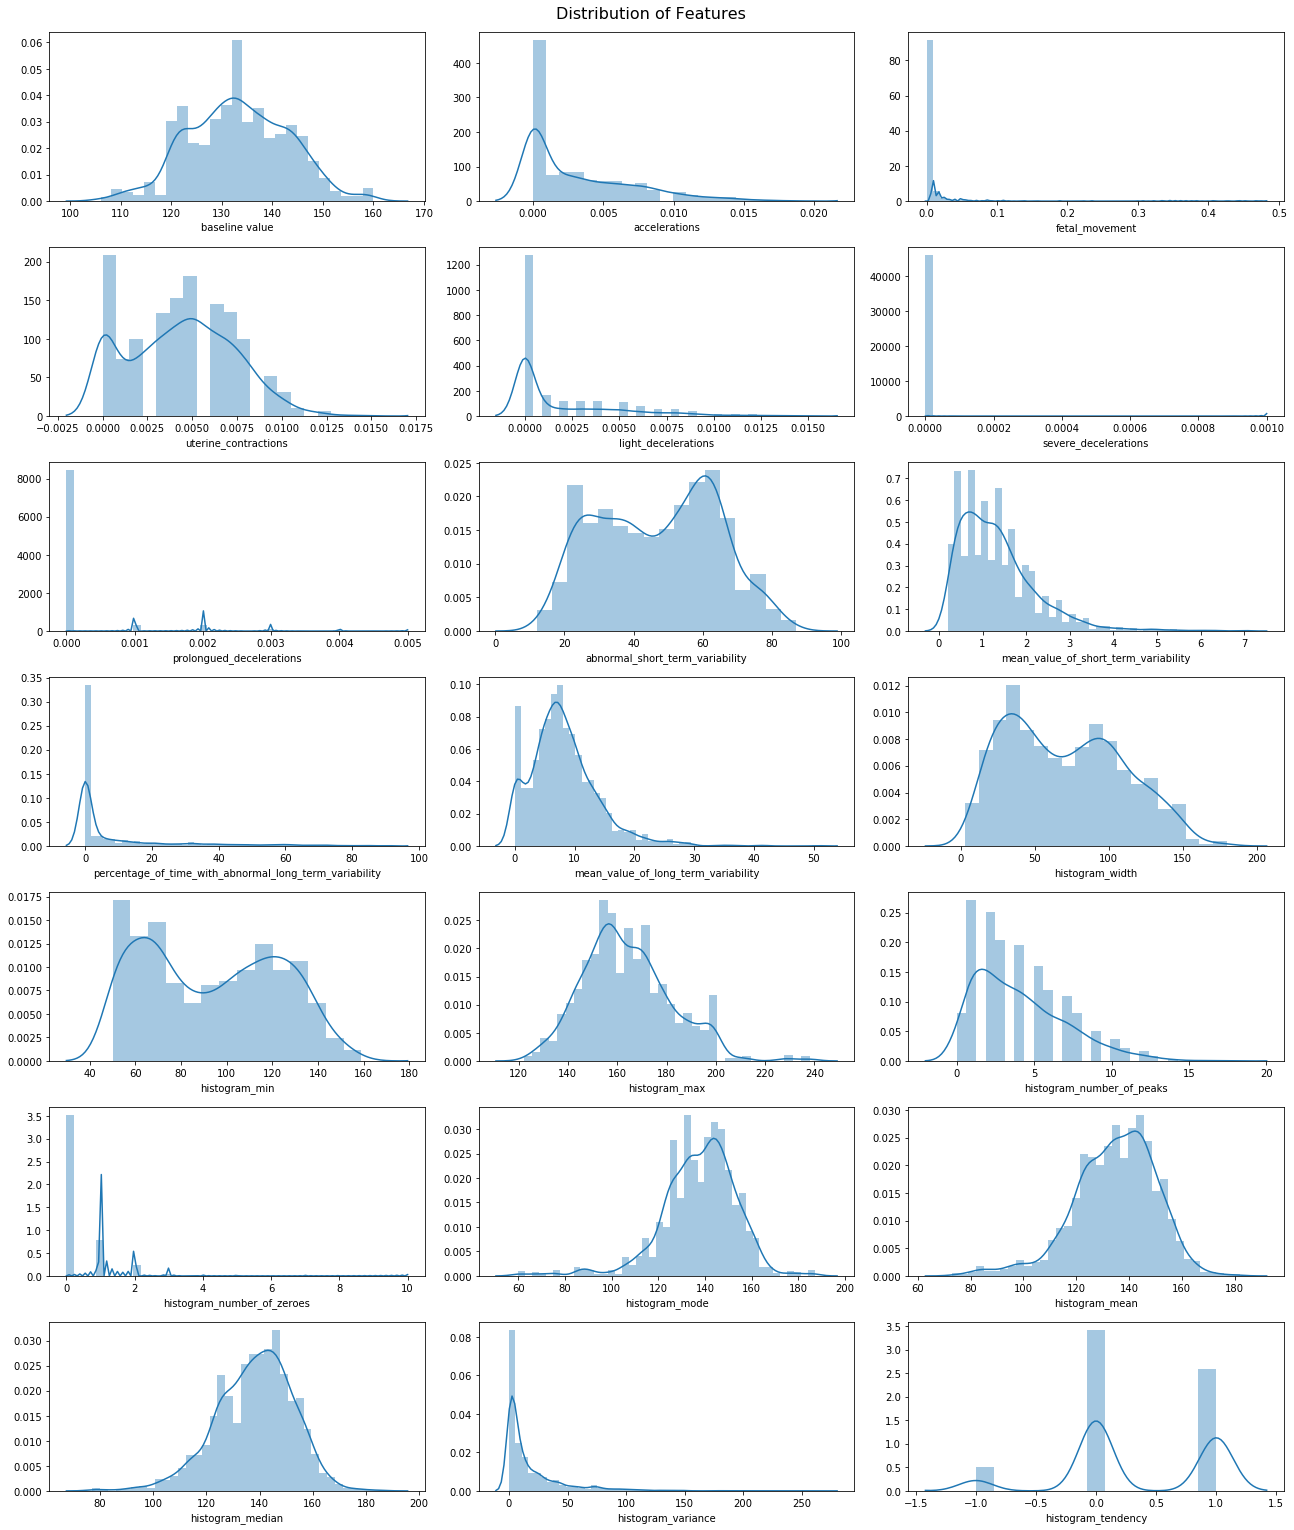

In [6]:
plt.figure(figsize=(18,21))
for i,col in enumerate(df.columns[:-1]):
    plt.subplot(7,3,i+1)
    sns.distplot(df[col])
plt.suptitle('Distribution of Features', size=16, y=1.01)
plt.tight_layout()
plt.show()

# 3번

전처리를 통해 모델링할 수 있게 데이터셋을 만들어봅시다!

In [7]:
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

**1) Target 변수들이 불균형하게 분포되어 있었습니다. 이를 해결하기 위해 SMOTE를 통해 Oversampling을 진행해주세요.**

In [8]:
smote = SMOTE(random_state=0)
X_res, y_res = smote.fit_sample(X, y)
print(f'Resampled dataset shape {Counter(y_res)}')

Resampled dataset shape Counter({2.0: 1655, 1.0: 1655, 3.0: 1655})


**2) 이제 train dataset과 test dataset으로 나눈 뒤 StandardScaler를 이용하여 데이터를 Scaling시켜주세요.**

In [9]:
# Q. 8주차 ppt p.29에서 SMOTE를 적용할 때는 train data set에만 오버샘플링 해야한다고 나와있는데
# 지금처럼 SMOTE를 진행하고 train/test set으로 나눠도 되는 건가용??

# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

# Scaling
scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

# 4번

이제 Modeling을 통해 데이터셋을 분류해봅시다!

논의의 편의성을 위해 XGBoost알고리즘 하나만을 이용하여 최적의 Hyperparameter를 찾아보겠습니다.

**1) RandomizedSearchCV로 최적 Hyperparameter 찾기**

RandomizedSearchCV를 통해 최적의 Hyperparameter를 찾아주세요!

param_grid = {'max_depth':[i for i in range(6,10)],
             'colsample_bytree':[0.25,0.5,0.75,1],
             'min_child_weight':[i for i in range(1,6)]}
             
scoring = 'accuracy', n_iter = 10)         

In [10]:
xgb = XGBClassifier(n_estimaters=100)

param_grid = {'max_depth':[i for i in range(6,10)], 
              'colsample_bytree':[0.25,0.5,0.75,1], 
              'min_child_weight':[i for i in range(1,6)]}

rcv = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='accuracy', n_iter=10)
rcv.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(n_estimaters=100),
                   param_distributions={'colsample_bytree': [0.25, 0.5, 0.75,
                                                             1],
                                        'max_depth': [6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4, 5]},
                   scoring='accuracy')

In [11]:
print('final params: ',rcv.best_params_)
print('best score: ', rcv.best_score_)

final params:  {'min_child_weight': 2, 'max_depth': 7, 'colsample_bytree': 0.75}
best score:  0.9758273381294964


**2) 찾아낸 Parameter를 통해 다시 학습시킨 뒤 아래 함수를 이용하여 이 모델을 평가해주세요.**

In [12]:
def get_clf_eval(y_test, pred):
    confusion_mat = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred,average = 'macro')
    F1_score = f1_score(y_test, pred,average = 'macro')
    
    print('Confusion Matrix')
    print(confusion_mat)
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_score: {F1_score:.4f}')

In [22]:
# 학습
xgb = XGBClassifier(n_estimator=1000, min_child_weight=2, max_depth=7, colsample_bytree=0.75)
xgb.fit(X_train, y_train)

# 예측
pred = xgb.predict(X_test)

# 평가
get_clf_eval(y_test, pred)

Confusion Matrix
[[486  10   1]
 [  5 493   1]
 [  2   3 489]]
Accuracy: 0.9852
Precision: 0.9853
Recall: 0.9852
F1_score: 0.9853


**3) plot_importance를 통해 분류를 하는데 있어 가장 중요한 2개의 Feature를 적어주세요.**

Answer: abnormal_short_term_variability & percentage_of_time_with_abnormal_long_term_variability

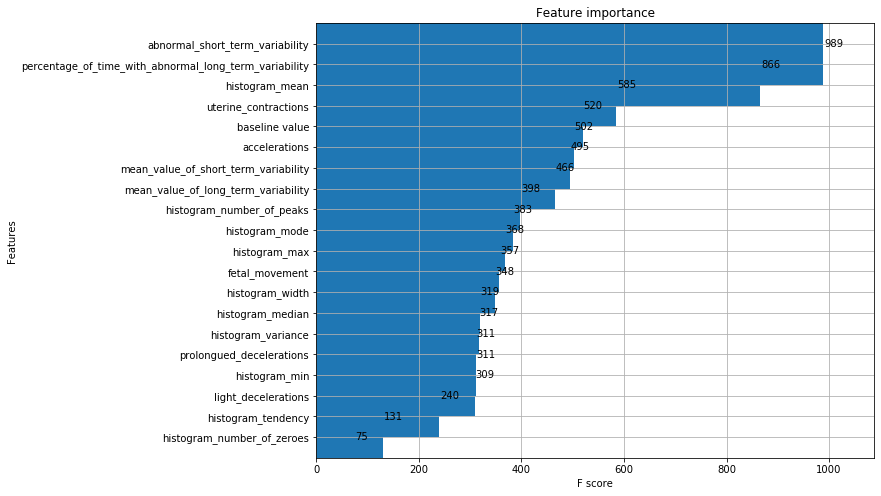

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb, ax=ax, max_num_features=20, height=4)
plt.show()

# 5번

Q. Stacking과 지난주에 배운 Ensemble의 차이점은 무엇인지 서술해주세요.


Answer: 모두 개별 알고리즘을 결합해 모델 성능을 개선하는 방법입니다. 단, 스태킹 앙상블의 개별 모델이 예측한 데이터를 스태킹 형태로 쌓고, 이를 새로운 학습데이터로 사용해 최종 모델이 다시 학습 및 예측을 수행한다는 점이 다릅니다. 

Stacking을 통해 모델의 성능을 최대한 끌어 올려보도록 하겠습니다.

아래 함수를 이용하여 자유롭게 Stacking 모델을 디자인해주세요!

In [15]:
#array를 통해 indexing하기 편하게 코드가 짜여있기 때문에 아래 데이터셋을 함수에 넣어주세요.
#Ex) get_meta(clf,X_train_array,y_train_array,X_test_aarray,nfold = 5)

X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
y_train_array = np.array(y_train)

In [16]:
def get_meta(clf,X_train,y_train,X_test,nfold = 5):
    kf = KFold(n_splits = nfold, shuffle=True)
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    meta_train = np.zeros((ntrain,1))
    meta_test = np.zeros((ntest,nfold))

    
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]

        clf.fit(X_tr, y_tr)

        meta_train[test_index,:] = clf.predict(X_te).reshape(-1,1)
        meta_test[:, i] = clf.predict(X_test)

    meta_test = meta_test.mean(axis=1).reshape(-1,1)
    
    return meta_train, meta_test

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
# 개별 모델
knn_clf  = KNeighborsClassifier(n_neighbors=4)
lr_clf = LogisticRegression(C=10)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=1000)

# 최종 모델: 랜덤 포레스트
rf_final = RandomForestClassifier(n_estimators=1000, random_state=0)

In [19]:
# 개별 모델 
knn_train, knn_test = get_meta(knn_clf, X_train_array, y_train_array, X_test_array, 10)
lr_train, lr_test = get_meta(lr_clf, X_train_array, y_train_array, X_test_array, 10)
dt_train, dt_test = get_meta(dt_clf, X_train_array, y_train_array, X_test_array,  10)    
ada_train, ada_test = get_meta(ada_clf, X_train_array, y_train_array, X_test_array, 10)

In [20]:
# 스태킹 앙상블 
Stack_final_X_train = np.concatenate((knn_train, lr_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, lr_test, dt_test, ada_test), axis=1)

In [21]:
# 최종 메타 모델
rf_final.fit(Stack_final_X_train, y_train)
stack_final = rf_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9738
